# WDSC-Football Forecasting 2023

# Importing libraries

In [1]:
# Dependencies
from scipy.stats import poisson 
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Gathering our data

# Data for the week calendar 

In [2]:
calendar = pd.read_csv("./epl-2022-UTC.csv", sep=",", encoding="utf-8")

In [3]:
calendar = calendar[['Round Number','Date','Home Team','Away Team']].copy()
calendar=calendar.fillna(0)
calendar_week=calendar[calendar['Round Number']==28]

In [4]:
calendar_week

,Round Number,Date,Home Team,Away Team
270,28,18/03/2023 15:00,Arsenal,Crystal Palace
271,28,18/03/2023 15:00,Aston Villa,Bournemouth
272,28,18/03/2023 15:00,Brentford,Leicester
273,28,18/03/2023 15:00,Brighton,Man Utd
274,28,18/03/2023 15:00,Chelsea,Everton
275,28,18/03/2023 15:00,Liverpool,Fulham
276,28,18/03/2023 15:00,Man City,West Ham
277,28,18/03/2023 15:00,Nottingham Forest,Newcastle
278,28,18/03/2023 15:00,Southampton,Spurs
279,28,18/03/2023 15:00,Wolves,Leeds


In [5]:
dict = {'Nottingham Forest': "Nott'm Forest",
       'Man Utd': 'Man United',
       'Spurs': 'Tottenham'}

calendar_week.replace({'Home Team': dict}, inplace=True)
calendar_week.replace({'Away Team': dict}, inplace=True)

/var/folders/lw/wf82f57x0rs9dlnjr6z3l0s80000gn/T/ipykernel_20748/3054149329.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_week.replace({'Home Team': dict}, inplace=True)
/var/folders/lw/wf82f57x0rs9dlnjr6z3l0s80000gn/T/ipykernel_20748/3054149329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_week.replace({'Away Team': dict}, inplace=True)


# Data for our predictions 

In [6]:
#Taking all data from the last five years excluding 2020

# Get data from the 2018/2019 season
data1819 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/E0.csv", sep=',', engine='python',quoting=3) 

# Get data from the 2021/2022 season
data2122 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/E0.csv", sep=',', engine='python',quoting=3) 

# Get data from the 2022/2023 season
data2223 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2223/E0.csv", sep=',', engine='python',quoting=3) 

frames = [data1819, data2122, data2223]
  
data = pd.concat(frames)
data

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1,0,...,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1,0,...,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1,0,...,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82
4,E0,14/08/2021,15:00,Everton,Southampton,3,1,H,0,1,...,1.67,-0.50,2.05,1.88,2.05,1.88,2.08,1.90,2.03,1.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,E0,11/03/2023,17:30,Crystal Palace,Man City,0,1,A,0,0,...,1.98,1.50,1.84,2.09,1.84,2.09,1.90,2.13,1.84,2.05
257,E0,12/03/2023,14:00,Fulham,Arsenal,0,3,A,0,3,...,2.10,1.25,1.97,1.96,1.96,1.96,1.97,2.05,1.90,1.97
258,E0,12/03/2023,14:00,Man United,Southampton,0,0,D,0,0,...,2.61,-1.75,1.99,1.94,2.04,1.88,2.04,1.95,1.98,1.90
259,E0,12/03/2023,14:00,West Ham,Aston Villa,1,1,D,1,1,...,1.73,-0.25,2.04,1.89,2.06,1.88,2.06,1.97,1.99,1.89


In [7]:
data.HomeTeam.unique()

array(['Brentford', 'Man United', 'Burnley', 'Chelsea', 'Everton',
       'Leicester', 'Watford', 'Norwich', 'Newcastle', 'Tottenham',
       'Liverpool', 'Aston Villa', 'Crystal Palace', 'Leeds', 'Man City',
       'Brighton', 'Southampton', 'Wolves', 'Arsenal', 'West Ham',
       'Fulham', 'Bournemouth', "Nott'm Forest"], dtype=object)

# Light Cleaning

In [8]:
# Filtering columns of interest
columns = ["HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]
data = data[columns]

# Renaming columns
data = data.rename(
    columns={"FTHG": "HomeGoals", "FTAG": "AwayGoals", "FTR": "Result"}
)

In [9]:
# Remove final week of fixtures
data[:-10]
data.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result
0,Brentford,Arsenal,2,0,H
1,Man United,Leeds,5,1,H
2,Burnley,Brighton,1,2,A
3,Chelsea,Crystal Palace,3,0,H
4,Everton,Southampton,3,1,H


# Understanding our dataset

Text(0.5, 1.0, 'Number of Goals Scored Per Match')

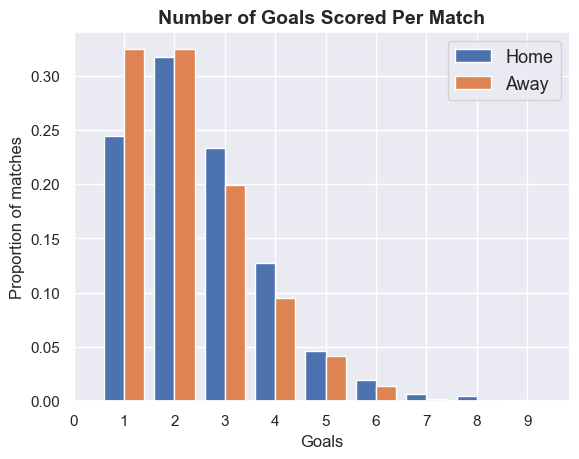

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

max_goals = 10
plt.hist(
    data[["HomeGoals", "AwayGoals"]].values, range(max_goals), label=["Home", "Away"], density=True
)
plt.xticks([i - 0.5 for i in range(max_goals)], [i for i in range(max_goals)])
plt.xlabel("Goals")
plt.ylabel("Proportion of matches")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of Goals Scored Per Match", size=14, fontweight="bold")

# Home Team Avantage

In [11]:
# Compute the average number of home and away goals 
data[['HomeGoals', 'AwayGoals']].mean()

HomeGoals    1.531832
AwayGoals    1.255632
dtype: float64

# Towards a match prediction model 

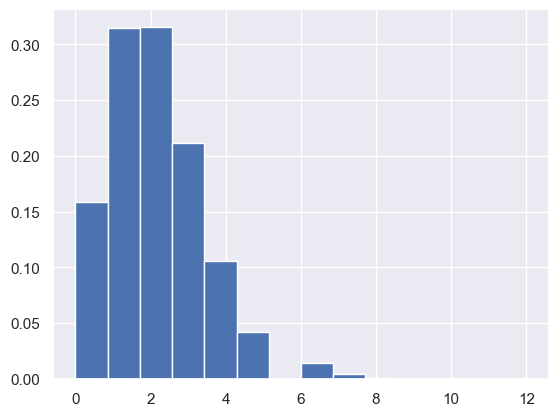

In [12]:
# Here we simulate 1 million samples from a Poisson distribution with a mean of two
x = np.random.poisson(2, 1000000)
plt.hist(x, 14, density=True)
plt.show()

In [13]:
#### PREPARE THE DATASET ####

# Separate home goals data
home_goals = data[["HomeTeam", "AwayTeam", "HomeGoals"]]
home_goals = home_goals.assign(home=1)
home_goals = home_goals.rename(
    columns={"HomeTeam": "team",
             "AwayTeam": "opponent", 
             "HomeGoals": "goals"}
)

# Separate away goals data 

# Separate home goals data
away_goals = data[["AwayTeam", "HomeTeam", "AwayGoals"]]
away_goals = away_goals.assign(home=0)
away_goals = away_goals.rename(
    columns={"AwayTeam": "team",
             "HomeTeam": "opponent", 
             "AwayGoals": "goals"}
)

In [14]:
# Concatenating into training data 
training_data = pd.concat([home_goals, away_goals])
training_data.head()

,team,opponent,goals,home
0,Brentford,Arsenal,2,1
1,Man United,Leeds,5,1
2,Burnley,Brighton,1,1
3,Chelsea,Crystal Palace,3,1
4,Everton,Southampton,3,1


# Build the model

In [15]:
# Building the model
# Poisson Regression: log-linear model
poisson_model = smf.glm(
    formula="goals ~ home + team + opponent",
    data=training_data,
    family=sm.families.Poisson() 
).fit()

In [16]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 2042
Model:                            GLM   Df Residuals:                     1996
Model Family:                 Poisson   Df Model:                           45
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2920.4
Date:                Wed, 15 Mar 2023   Deviance:                       2230.8
Time:                        09:46:39   Pearson chi2:                 1.93e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2222
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3109      0.120      2.580      0.010       0.075       0.547
team[T.Aston Villa]           -0.2794      0.113     -2.465      0.014      -0.502      -0.057
team[T.Bournemouth]           -0.5472      0.214     -2.558      0.011      -0.966      -0.128
team[T.Brentford]             -0.2757      0.113     -2.433      0.015      -0.498      -0.054
team[T.Brighton]              -0.3233      0.115     -2.812      0.005      -0.549      -0.098
team[T.Burnley]               -0.6856      0.142     -4.823      0.000      -0.964      -0.407
team[T.Chelsea]               -0.0253      0.105     -0.240      0.810      -0.231       0.181
team[T.Crystal Palace]        -0.3955      0.117     -3.375      0.001      -0.625      -0.166
team[T.Everton]               -0.5360      0.122     -4.386      0.000      -0.775      -0.296
team[T.Fulham]                -0.1928      0.179     -1.077      0.281      -0.544       0.158
team[T.Leeds]                 -0.4291      0.119     -3.604      0.000      -0.662      -0.196
team[T.Leicester]             -0.1013      0.108     -0.936      0.349      -0.313       0.111
team[T.Liverpool]              0.2450      0.099      2.485      0.013       0.052       0.438
team[T.Man City]               0.3538      0.096      3.681      0.000       0.165       0.542
team[T.Man United]            -0.1458      0.109     -1.334      0.182      -0.360       0.068
team[T.Newcastle]             -0.3492      0.116     -3.008      0.003      -0.577      -0.122
team[T.Norwich]               -1.0465      0.165     -6.339      0.000      -1.370      -0.723
team[T.Nott'm Forest]         -0.7587      0.231     -3.284      0.001      -1.211      -0.306
team[T.Southampton]           -0.5216      0.122     -4.271      0.000      -0.761      -0.282
team[T.Tottenham]              0.0248      0.104      0.238      0.812      -0.179       0.229
team[T.Watford]               -0.6617      0.142     -4.654      0.000      -0.940      -0.383
team[T.West Ham]              -0.2218      0.111     -1.990      0.047      -0.440      -0.003
team[T.Wolves]                -0.6414      0.126     -5.089      0.000      -0.888      -0.394
opponent[T.Aston Villa]        0.1871      0.123      1.521      0.128      -0.054       0.428
opponent[T.Bournemouth]        0.4372      0.168      2.609      0.009       0.109       0.766
opponent[T.Brentford]          0.1912      0.123      1.550      0.121      -0.051       0.433
opponent[T.Brighton]          -0.0115      0.129     -0.089      0.929      -0.265       0.242
opponent[T.Burnley]            0.1457      0.133      1.093      0.274      -0.116       0.407
opponent[T.Chelsea]           -0.2670      0.139     -1.928      0.054      -0.538       0.004
opponent[T.Crystal Palace]     0.0084      

# Computing the expected goals for each team

In [17]:
# Create feature data for home and away team for the match
def create_X(home_team, away_team):
    X_home = pd.DataFrame(data={"team": home_team,
                                "opponent": away_team,
                                "home": 1
                                }, index=[1])
    
    # Creating DataFrame for away team features
    X_away = pd.DataFrame(data={"team": away_team,
                                "opponent": home_team,
                                "home": 0
                                }, index=[1])
    
    return X_home, X_away

In [18]:
def predict_avg_goals(X_home, X_away, model):
    # Predict the mean number of goals for home team
    home_goals_avg = model.predict(X_home) 
    
    # Predict the mean number of goals for away team
    away_goals_avg = model.predict(X_away) 
    
    return home_goals_avg, away_goals_avg

In [19]:
# Predicting average goals for Chelsea Man City match
X_home, X_away =  create_X('Brighton', "Nott'm Forest")
avg_goals = predict_avg_goals(X_home, X_away, poisson_model)
print('Average Home Goals: ', avg_goals[0].values[0])

# Fill in to print the average away goals
print('Average Away Goals: ', avg_goals[1].values[0])

Average Home Goals:  1.7220310969045303
Average Away Goals:  0.6317518625725689


# Computing the distribution of match scores

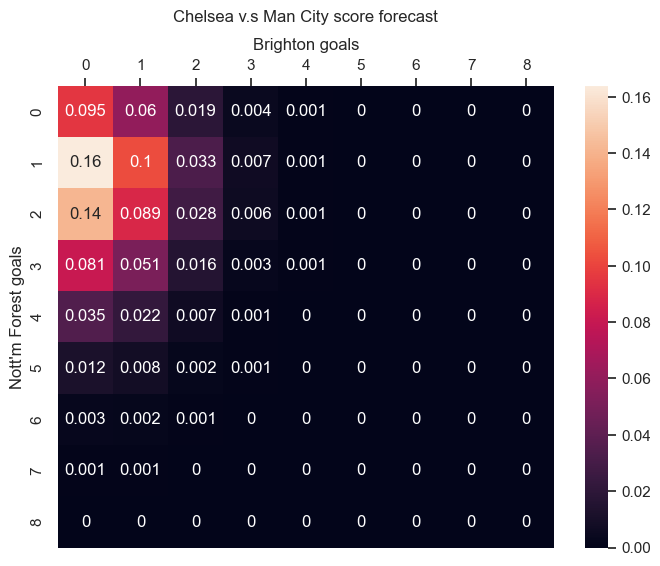

In [20]:
# Funciton to forecast a given match
# Probability Mass Function
def predict_score_pmf(X_home, X_away, model, max_goals):
    
    # Predict the average number of goals for home  and away teams
    avg_goals = predict_avg_goals(X_home, X_away, model)
    home_goals_avg = avg_goals[0]
    away_goals_avg = avg_goals[1]

    # Compute marginal distribution for home goals
    home_goals_pmf = [poisson.pmf(i, home_goals_avg)
                      for i in range(0, max_goals + 1)]

    # Compute marginal distribution for away goals 
    away_goals_pmf = [poisson.pmf(i, away_goals_avg)
                      for i in range(0, max_goals + 1)]

    # Compute joint distribution for match score as outer product
    joint_pmf = np.outer(np.array(home_goals_pmf),
                         np.array(away_goals_pmf))
    
    return joint_pmf

# Predicting distribution of match scores
X_home, X_away =  create_X('Brighton', "Nott'm Forest")
score_pmf = predict_score_pmf(X_home, X_away, poisson_model, 8)
score_pmf = score_pmf.round(3)

# Visualizing distribution in a heatmap
f, axs = plt.subplots(figsize=(8, 6))
sns.heatmap(score_pmf, annot=True)
axs.xaxis.tick_top() # x axis on top
axs.xaxis.set_label_position('top')
plt.title("Chelsea v.s Man City score forecast", y=1.12)
plt.xlabel("Brighton goals", labelpad=6)
plt.ylabel("Nott'm Forest goals")
plt.show()

# Forecasting the distribution mode¶

In [21]:
def predict_score(X_home, X_away, model):
    # Predicting distribution of match scores
    score_pmf = predict_score_pmf(X_home, X_away, model,16)
    score_pmf = score_pmf.round(3)
    
    # Computing distribution mode
    home_goals_mode = np.argmax(score_pmf) // (17)
    away_goals_mode = np.argmax(score_pmf) % (17)
    score_pred = (home_goals_mode, away_goals_mode)
    return score_pred

In [22]:
for i in range(0, len(calendar_week)):
    print ("1- Match predicted results:  "+ calendar_week['Home Team'].iloc[i]+"  and  "+ calendar_week['Away Team'].iloc[i])
    X_home, X_away =  create_X(calendar_week['Home Team'].iloc[i],calendar_week['Away Team'].iloc[i])
    score_pred =  predict_score(X_home, X_away, poisson_model)
    print('Score Forecast: ', score_pred)
    

1- Match predicted results:  Arsenal  and  Crystal Palace
Score Forecast:  (1, 0)
1- Match predicted results:  Aston Villa  and  Bournemouth
Score Forecast:  (1, 0)
1- Match predicted results:  Brentford  and  Leicester
Score Forecast:  (1, 1)
1- Match predicted results:  Brighton  and  Man United
Score Forecast:  (1, 1)
1- Match predicted results:  Chelsea  and  Everton
Score Forecast:  (2, 0)
1- Match predicted results:  Liverpool  and  Fulham
Score Forecast:  (2, 0)
1- Match predicted results:  Man City  and  West Ham
Score Forecast:  (2, 0)
1- Match predicted results:  Nott'm Forest  and  Newcastle
Score Forecast:  (0, 1)
1- Match predicted results:  Southampton  and  Tottenham
Score Forecast:  (0, 1)
1- Match predicted results:  Wolves  and  Leeds
Score Forecast:  (1, 0)


# Accuracy of our predictions : Determining Weighting 

In [26]:
def mse(y_true, ypred):
    np.square(np.subtract(Y_true,Y_pred)).mean()

In [27]:
model = CatBoostRegressor(objective='Poisson')

model.fit(training_data, plot=True, eval_set=val_pool, verbose=500)

actual_counts = df_test.favorite_count.values.astype(int) 
predicted_counts_poisson = model.predict(test_pool) * 100
r2_poisson = r2_score(actual_counts, predicted_counts_poisson)
rmse_score_poisson_model = np.sqrt(mean_squared_error(actual_counts, predicted_counts_poisson))
print('R2 score: {:.3f}\nRMSE score: {:.2f}'.format(r2_poisson, rmse_score_poisson_model))

NameError: name 'CatBoostRegressor' is not defined

In [ ]:
print(accuracy_score(ytest, model.predict(xtest)))

In [ ]:
accuracy = metrics.accuracy_score(y_test, preds)
accuracy 

# Webscrapping - team results of the previous weeks 

In [ ]:
#webscrapping - team results of the weeks 
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
url = "https://fixturedownload.com/results/epl-2022"
data = requests.get(url).text

In [ ]:
import requests
import lxml.html as lh
import pandas as pd

url='https://fixturedownload.com/results/epl-2022'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

In [ ]:
tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print ('%d:"%s"'%(i,name))
    col.append((name,[]))

In [ ]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=6:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1


In [ ]:
Dict={title:column for (title,column) in col}
update_score=pd.DataFrame(Dict)

In [ ]:
dict = {'Nottingham Forest': "Nott'm Forest",
       'Man Utd': 'Man United',
       'Spurs': 'Tottenham'}

update_score.replace({'Home Team': dict}, inplace=True)
update_score.replace({'Away Team': dict}, inplace=True)

In [ ]:
update_score.head()

In [ ]:
for i in range(0, len(update_score)):
    my_string = update_score['Result'].iloc[i]
    value1, value2 = my_string.split("-")
    update_score.loc[i, ['True_Home_Score']] = value1
    update_score.loc[i, ['True_Away_Score']] = value2


In [ ]:
update_score.dropna()


In [ ]:
update_score['Round Number']= update_score['Round Number'].astype(int)
update_score=update_score[update_score['Round Number'] >= 12]
update_score=update_score[update_score['Round Number'] <= 15]
update_score.reset_index(inplace = True, drop = True)
update_score

In [ ]:
for i in range(0, len(update_score)):
    X_home, X_away =  create_X(update_score['Home Team'].iloc[i],update_score['Away Team'].iloc[i])
    score_pmf = predict_score(X_home, X_away, poisson_model)
    my_string = str(score_pmf)
    value1, value2 = my_string.split(",")
    update_score.loc[i, ['Predicted_Home_Score']] = value1
    update_score.loc[i, ['Predicted_Away_Score']] = value2
    print(score_pmf)

In [ ]:
update_score

In [ ]:
#we need numbers 
update_score['Predicted_Home_Score']=update_score.Predicted_Home_Score.str.strip('()')
update_score['Predicted_Home_Score']=update_score['Predicted_Home_Score'].fillna(0)
update_score['Predicted_Home_Score']= update_score['Predicted_Home_Score'].astype(int)
update_score['Predicted_Away_Score']=update_score.Predicted_Away_Score.str.strip('()')
update_score['Predicted_Away_Score']=update_score['Predicted_Away_Score'].fillna(0)
update_score['Predicted_Away_Score']= update_score['Predicted_Away_Score'].astype(int)

In [ ]:
update_score=update_score.drop(update_score.index[3])

In [ ]:
update_score = update_score[:34]

In [ ]:
update_score['True_Home_Score']= update_score['True_Home_Score'].astype(int)
update_score['True_Away_Score']= update_score['True_Away_Score'].astype(int)
update_score['Predicted_Home_Score']= update_score['Predicted_Home_Score'].astype(int)

In [ ]:
update_score.head()

In [ ]:
update_score.reset_index(inplace = True, drop = True)

In [ ]:
#add a prediction columns + real score 
# and compute the accuracy !!!!!!

In [ ]:
def accuracy_competition(homepred,awaypred,truehome,trueaway):
    a = 1-(((homepred-truehome)^2 + (awaypred-trueaway)^2 )/(1+homepred+awaypred+truehome+trueaway))
    return a 

In [ ]:
for i in range(0, len(update_score)):
    a = 1-(((update_score['Predicted_Home_Score'].loc[i]-update_score['True_Home_Score'].loc[i])^2 + (update_score['Predicted_Away_Score'].loc[i]-update_score['True_Away_Score'].loc[i])^2 )/(1+update_score['Predicted_Away_Score'].loc[i]+update_score['True_Away_Score'].loc[i]+update_score['Predicted_Home_Score'].loc[i]+update_score['True_Home_Score'].loc[i]))
    update_score.loc[i, ['Accuracy']] = a

In [ ]:
#my
large5 = update_score.nlargest(10, "Accuracy")
large5

In [ ]:
lowest10 = update_score.set_index('Home Team').groupby('Accuracy', as_index=False).idxmax()
lowest10
print("The top 3 : Highest predictions accuracy are for the home team")
print(lowest10.loc[15])
print(lowest10.loc[14])
print(lowest10.loc[13])

In [ ]:
lowest10 = update_score.set_index('Away Team').groupby('Accuracy', as_index=False).idxmax()
lowest10
print("The top 3 : Highest predictions accuracy are for the away team")
print(lowest10.loc[15])
print(lowest10.loc[14])
print(lowest10.loc[13])

In [ ]:
# for week 16 , we weight our prediction taking into the both top 3 
#Nott'm Forest, Crystal Palace, Brighton, Liverpool, Wolves, Chelsea
#we give each team who plays 15 weight

In [ ]:
calendar_week

In [ ]:
number_of_games = calendar_week.shape
number_of_games[0]